In [2]:
import pandas as pd
import geopandas as gpd
from matplotlib import pyplot as plt
import matplotlib as mpl
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
import os
import seaborn as sns
import cartogram
import circlify
from pathlib import Path
import unicodedata

In [3]:
# Prepare, parse, and save data files used in this exploration
def remove_accents(text):
    if pd.isna(text):
        return text
    # Normalize unicode and remove combining diacritics
    return ''.join(
        c for c in unicodedata.normalize('NFKD', str(text))
        if not unicodedata.combining(c)
    )

def summarize(df, column):
    if column not in df.columns:
        print(f"Column '{column}' not found in dataframe.")
        return
    
    series = df[column].dropna()
    print(f"--- Summary for: {column} ---")
    print(f"Count:      {series.count()}")
    print(f"Mean:       {series.mean():.2f}")
    print(f"Median:     {series.median():.2f}")
    print(f"Std Dev:    {series.std():.2f}")
    print(f"Min:        {series.min():.2f}")
    print(f"Max:        {series.max():.2f}")
    print("\nPercentiles:")
    print(series.quantile([0.1, 0.25, 0.5, 0.75, 0.9]))
    print()
def group_summary(df, group_col, value_col):

    if group_col not in df.columns:
        raise ValueError(f"Group column '{group_col}' not found.")
    if value_col not in df.columns:
        raise ValueError(f"Value column '{value_col}' not found.")

    summary = (
        df.groupby(group_col)[value_col]
          .agg(['count', 'mean', 'median', 'std', 'min', 'max'])
          .sort_values('mean', ascending=False)
    )
    return summary

def clean_colname(col):
    col = ''.join(c for c in unicodedata.normalize('NFKD', str(col)) if not unicodedata.combining(c))
    col = col.upper().replace(' ', '_')
    return col

def clean_column(series):

    series = series.astype(str)
    series = series.replace(r'^\s*$', pd.NA, regex=True)
    series = series.str.replace(',', '.', regex=False)
    series = pd.to_numeric(series, errors='coerce')

    return series

def grouped_stats(df, group_col, value_cols, stats=None):
    if stats is None:
        stats = ['count', 'mean', 'median', 'std', 'min', 'max']

    if isinstance(value_cols, str):
        value_cols = [value_cols]

    result = {}

    for col in value_cols:
        if col not in df.columns:
            continue
        df_clean = df.dropna(subset=[col])
        result[col] = df_clean.groupby(group_col)[col].agg(stats)

    return result

def plot_histogram(df, col, bins=20, kde=True):
    if col not in df.columns:
        print(f"{col} not in DataFrame")
        return
    
    plt.figure(figsize=(10, 5))
    sns.histplot(df[col].dropna(), bins=bins, kde=kde)
    plt.title(f"Histogram of {col}")
    plt.xlabel(col)
    plt.tick_params(axis='x', labelrotation=90)
    plt.ylabel("Count")
    plt.show()

def load_csv_clean(path):
    data = []
    with open(path, newline='', encoding='utf-8') as f:
        reader = csv.reader(f)
        for row in reader:
            data.append(row)

    df = pd.DataFrame(data)
    
    df.columns = df.iloc[0]
    df = df[1:].reset_index(drop=True)
    df.columns = [clean_colname(col) for col in df.columns]
    
    return df

shared_cols = [
    'ANY', 'ANY_NAIXEMENT', 'CODI_ALUMNE', 'MES_NAIXEMENT',
    'PANG','PANG_CO','PANG_EE','PCAST','PCAST_CL','PCAST_EE',
    'PCAT','PCAT_CL','PCAT_EE','PFRAN','PFRAN_CO','PFRAN_EE',
    'PMAT','PMAT_CR','PMAT_EFM','PMAT_NC'
]


In [ ]:
##### PLACE LOCAL DATA PATH HERE #####
#     Filetype: csv -> pd dataframe  #
df_S = load_csv_clean("..")
df_P = load_csv_clean("..")

In [ ]:
# RAW CSV DATA CLEANING #
# SKIP TO NEXT CELL IF DONE BEFORE #
shared_cols = df_S.columns.intersection(df_P.columns)

# Keep only rows where CODI_ALUMNE exists
df_P = df_P.dropna(subset=['CODI_ALUMNE']).copy()
df_S = df_S.dropna(subset=['CODI_ALUMNE']).copy()

# Keep only rows where CODI_ALUMNE is not NaN and not an empty string
df_S = df_S[df_S['CODI_ALUMNE'].notna() & (df_S['CODI_ALUMNE'].astype(str).str.strip() != "")].copy()
df_P = df_P[df_P['CODI_ALUMNE'].notna() & (df_P['CODI_ALUMNE'].astype(str).str.strip() != "")].copy()


# Convert CODI_ALUMNE to int
df_P['CODI_ALUMNE'] = df_P['CODI_ALUMNE'].astype(int)
df_S['CODI_ALUMNE'] = df_S['CODI_ALUMNE'].astype(int)

# Drop duplicate IDS
df_P["CODI_ALUMNE"].drop_duplicates()
df_S["CODI_ALUMNE"].drop_duplicates()

# Keep only students present in both datasets
common_ids = set(df_P['CODI_ALUMNE']).intersection(df_S['CODI_ALUMNE'])
df_P = df_P[df_P['CODI_ALUMNE'].isin(common_ids)].copy()
df_S = df_S[df_S['CODI_ALUMNE'].isin(common_ids)].copy()

# Keep only shared columns that exist in both
df_P = df_P[shared_cols].copy()
df_S = df_S[shared_cols].copy()

# Add LEVEL column
df_P['LEVEL'] = 'PRIMARIA'
df_S['LEVEL'] = 'SECUNDARIA'

csv_path = "../Data/Secundaria.csv"
df_S.to_csv(csv_path)

csv_path = "../Data/Primaria.csv"
df_P.to_csv(csv_path)

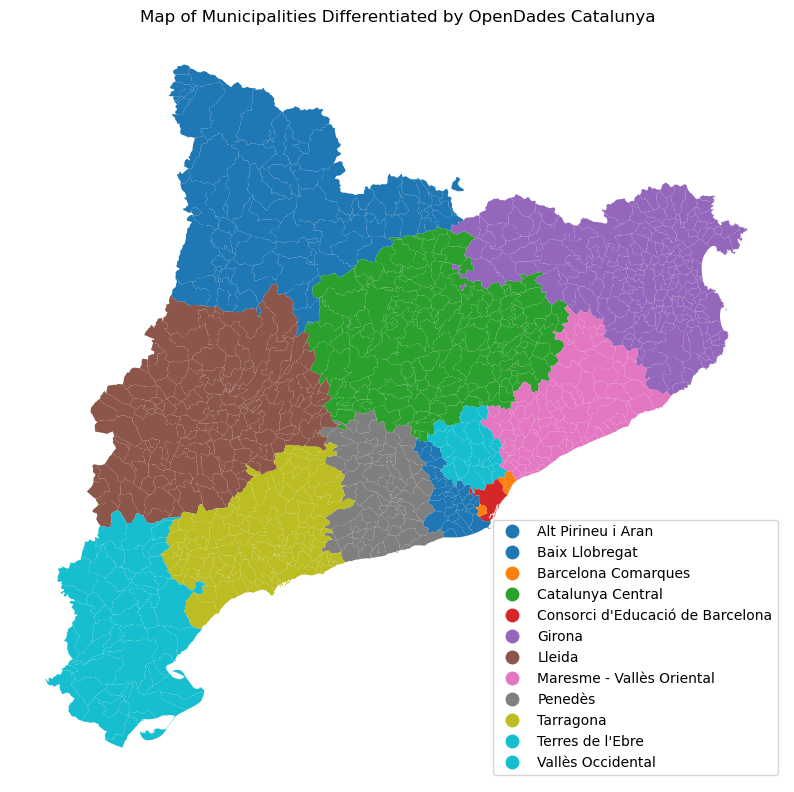

In [5]:
# Get the list of all shp files in BCN500 directory
dir_cat = [x for x in os.listdir("../Notebooks/MapFiles/") if x[-4:]==".shp"]

# first number: resolution/ scale, second number: Date
dir_cat = [x for x in os.listdir("../Notebooks/MapFiles/") if x[-20:]=="-500000-20250730.shp"]
ids = {x:x[31:-20] for x in dir_cat}

ids.keys

cat_maps = {}
maps = dir_cat[0]
cat_maps[ids[maps]] = gpd.read_file("../Notebooks/MapFiles/"+maps)
municipis = cat_maps[ids[maps]]
municipis['NOMREGIO'] = ""

## Construct the regions that the Competencies data set uses ##
# Has to be done in this order to properly override subset rewriting
#1: Provincias
municipis.loc[municipis["NOMPROV"] == "Lleida", "NOMREGIO"] = "Lleida"
municipis.loc[municipis["NOMPROV"] == "Girona", "NOMREGIO"] = "Girona"
municipis.loc[municipis["NOMPROV"] == "Tarragona", "NOMREGIO"] = "Tarragona"
municipis.loc[municipis["NOMPROV"] == "Barcelona", "NOMREGIO"] = "Barcelona Comarques"
#2: Vegueres
municipis.loc[municipis["NOMVEGUE"] == "Penedès", "NOMREGIO"] = "Penedès"
municipis.loc[municipis["NOMVEGUE"] == "Terres de l'Ebre", "NOMREGIO"] = "Terres de l'Ebre"
municipis.loc[municipis["NOMVEGUE"] == "Catalunya Central", "NOMREGIO"] = "Catalunya Central"
municipis.loc[municipis["NOMVEGUE"] == "Alt Pirineu", "NOMREGIO"] = "Alt Pirineu i Aran"
municipis.loc[municipis["NOMVEGUE"] == "Val d'Aran (entitat territorial singular)", "NOMREGIO"] = "Alt Pirineu i Aran"

#3: Comarcas
municipis.loc[municipis["NOMCOMAR"] == "Vallès Occidental", "NOMREGIO"] = "Vallès Occidental"
municipis.loc[municipis["NOMCOMAR"] == "Vallès Oriental", "NOMREGIO"] = "Maresme - Vallès Oriental"
municipis.loc[municipis["NOMCOMAR"] == "Maresme", "NOMREGIO"] = "Maresme - Vallès Oriental"
municipis.loc[municipis["NOMCOMAR"] == "Selva", "NOMREGIO"] = "Maresme - Vallès Oriental"
municipis.loc[municipis["NOMCOMAR"] == "Baix Llobregat", "NOMREGIO"] = "Baix Llobregat"

#4: Municipality
municipis.loc[municipis["NOMMUNI"] == "Barcelona", "NOMREGIO"] = "Consorci d'Educació de Barcelona"

cat_mfig, ax = plt.subplots(figsize=(10, 10))
municipis.plot(column='NOMREGIO', ax=ax, legend=True, legend_kwds={'loc': 'lower right'})

# Customize the plot
plt.title('Map of Municipalities Differentiated by OpenDades Catalunya')
plt.axis('off')  # Turn off the axes
plt.show()


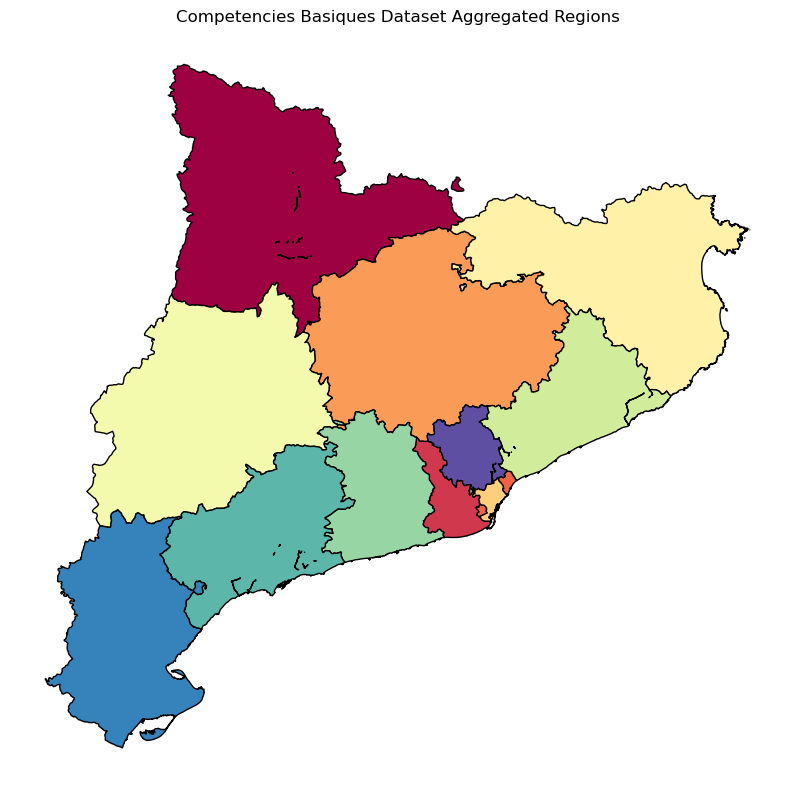

In [8]:
aggregated_regions = municipis.dissolve(by="NOMREGIO")

# Keep only the NOMREGIO and geometry columns in the new GeoDataFrame
aggregated_regions = aggregated_regions.reset_index()[["NOMREGIO", "geometry"]]

fig, ax = plt.subplots(figsize=(10, 10))
aggregated_regions.plot(ax=ax, cmap='Spectral', edgecolor='black')

plt.title('Competencies Basiques Dataset Aggregated Regions')
plt.axis('off') 
plt.show()

In [9]:
# Load from CSV
df_s = pd.read_csv("../Data/Secundaria.csv", header=0)
df_p = pd.read_csv("../Data/Primaria.csv", header=0)

# Replace empty values (or just spaces) with a NaN
df_s.replace(r'^\s*$', np.nan, regex=True, inplace=True)
df_p.replace(r'^\s*$', np.nan, regex=True, inplace=True)

#  str -> float
cols_to_clean = [
    'ANY', 'ANY_NAIXEMENT', 'MES_NAIXEMENT',
    'PANG','PANG_CO','PANG_EE','PCAST','PCAST_CL','PCAST_EE',
    'PCAT','PCAT_CL','PCAT_EE','PFRAN','PFRAN_CO','PFRAN_EE',
    'PMAT','PMAT_CR','PMAT_EFM','PMAT_NC'
]

# euro decimal -> decimal
for col in cols_to_clean:
    if col in df_s.columns:
        df_s[col] = (
            df_s[col]
            .astype(str)
            .str.replace(',', '.', regex=False)
            .astype(float)
        )
              
    if col in df_p.columns:
        
        df_p[col] = (
            df_p[col]
            .astype(str)
            .str.replace(',', '.', regex=False)
            .astype(float)
        )

df_p["AREA_TERRITORIAL"] = df_p["AREA_TERRITORIAL"].replace("Barcelonès", "Barcelona Comarques")
df_s["AREA_TERRITORIAL"] = df_s["AREA_TERRITORIAL"].replace("Barcelonès", "Barcelona Comarques")
df_p['CODI_ALUMNE'] = df_p['CODI_ALUMNE'].astype(int)
df_s['CODI_ALUMNE'] = df_s['CODI_ALUMNE'].astype(int)

# Save shape files
municipis.to_file("../Notebooks/MapFiles/municipis.shp", driver="ESRI Shapefile")
aggregated_regions.to_file("../Notebooks/MapFiles/regions.shp", driver="ESRI Shapefile")

/var/folders/_m/vj49vq3972b166bph370j1kw0000gn/T/ipykernel_35428/39677125.py:2: DtypeWarning: Columns (4,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df_s = pd.read_csv("../Data/Secundaria.csv", header=0)


In [83]:
maps = dir_cat[0]
cat_maps[ids[maps]] = gpd.read_file("../Notebooks/MapFiles/"+maps, crs="EPSG:4326")
prvncs = cat_maps[ids[maps]]


# if you waant to plot all 100+ municipalities from the Greater Catalunya Geopandas Structure #
plot_muni=False
if plot_muni:
    fig, ax = plt.subplots(figsize=(5, 5))
    municipis.plot(ax=ax, color='lightblue', edgecolor='blue', linewidth=0.5, alpha=0.5, label="Municipalities")
    prvncs.plot(ax=ax, color='none', edgecolor='red', linewidth=1.2, alpha=0.7, label="Provinces")
plt.show()

/Users/peterclark/opt/anaconda3/envs/ub-bigdata-viz/lib/python3.11/site-packages/pyogrio/raw.py:198: RuntimeWarning: driver ESRI Shapefile does not support open option CRS
  return ogr_read(


In [ ]:
# Read file we created
# This part of the DF cleaning ensures that we have a clean set of test data
# from each unique ID, this acts on a geodataframe, not the csv like before.

municipis = gpd.read_file("../Notebooks/MapFiles/municipis.shp")

df_s["CODI_ALUMNE"].groupby(by=df_s["AREA_TERRITORIAL"]).count()
df_p["ANY"].groupby(by=df_p["ANY"]).count()
df_p["NATURALESA"].value_counts()/df_p["NATURALESA"].count()
df_p["CODI_ALUMNE"].groupby(by=df_s["AREA_TERRITORIAL"]).count().sum()
regions = aggregated_regions.dissolve(by="NOMREGIO", as_index=False)

# Collate datasets into stats format
merged_s = regions.merge(
    df_s.groupby(by='AREA_TERRITORIAL', as_index=True).agg({
        'PCAT':lambda x: x[x != 0].mean(skipna=True),
        'PCAST':lambda x: x[x != 0].mean(skipna=True),
        'PANG':lambda x: x[x != 0].mean(skipna=True),
        'PMAT':lambda x: x[x != 0].mean(skipna=True),
        'GENERE': lambda x: (x == "D").sum() / x.count(),
        'NATURALESA': lambda y: (y=="Privat").sum() / y.count()
        }), left_on="NOMREGIO", right_on="AREA_TERRITORIAL", how="left")

merged_p = regions.merge(
    df_p.groupby(by='AREA_TERRITORIAL', as_index=True).agg({
        'PCAT':'mean',
        'PCAST':'mean',
        'PANG':'mean',
        'PMAT':'mean',
        'GENERE': lambda x: (x == "D").sum() / x.count(),
        'NATURALESA': lambda y: (y=="Privat").sum() / y.count()
        }), left_on="NOMREGIO", right_on="AREA_TERRITORIAL", how="left")

primary_regions=regions.merge(df_p, left_on="NOMREGIO", right_on="AREA_TERRITORIAL", how="left")
secondary_regions=regions.merge(df_s, left_on="NOMREGIO", right_on="AREA_TERRITORIAL", how="left")
merged = merged_s.copy()
merged["PCAT"] = merged_s['PCAT'] - merged_p['PCAT']

/var/folders/_m/vj49vq3972b166bph370j1kw0000gn/T/ipykernel_35428/2595663671.py:67: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  fontratio=(area_counts[i]/area_counts.max())


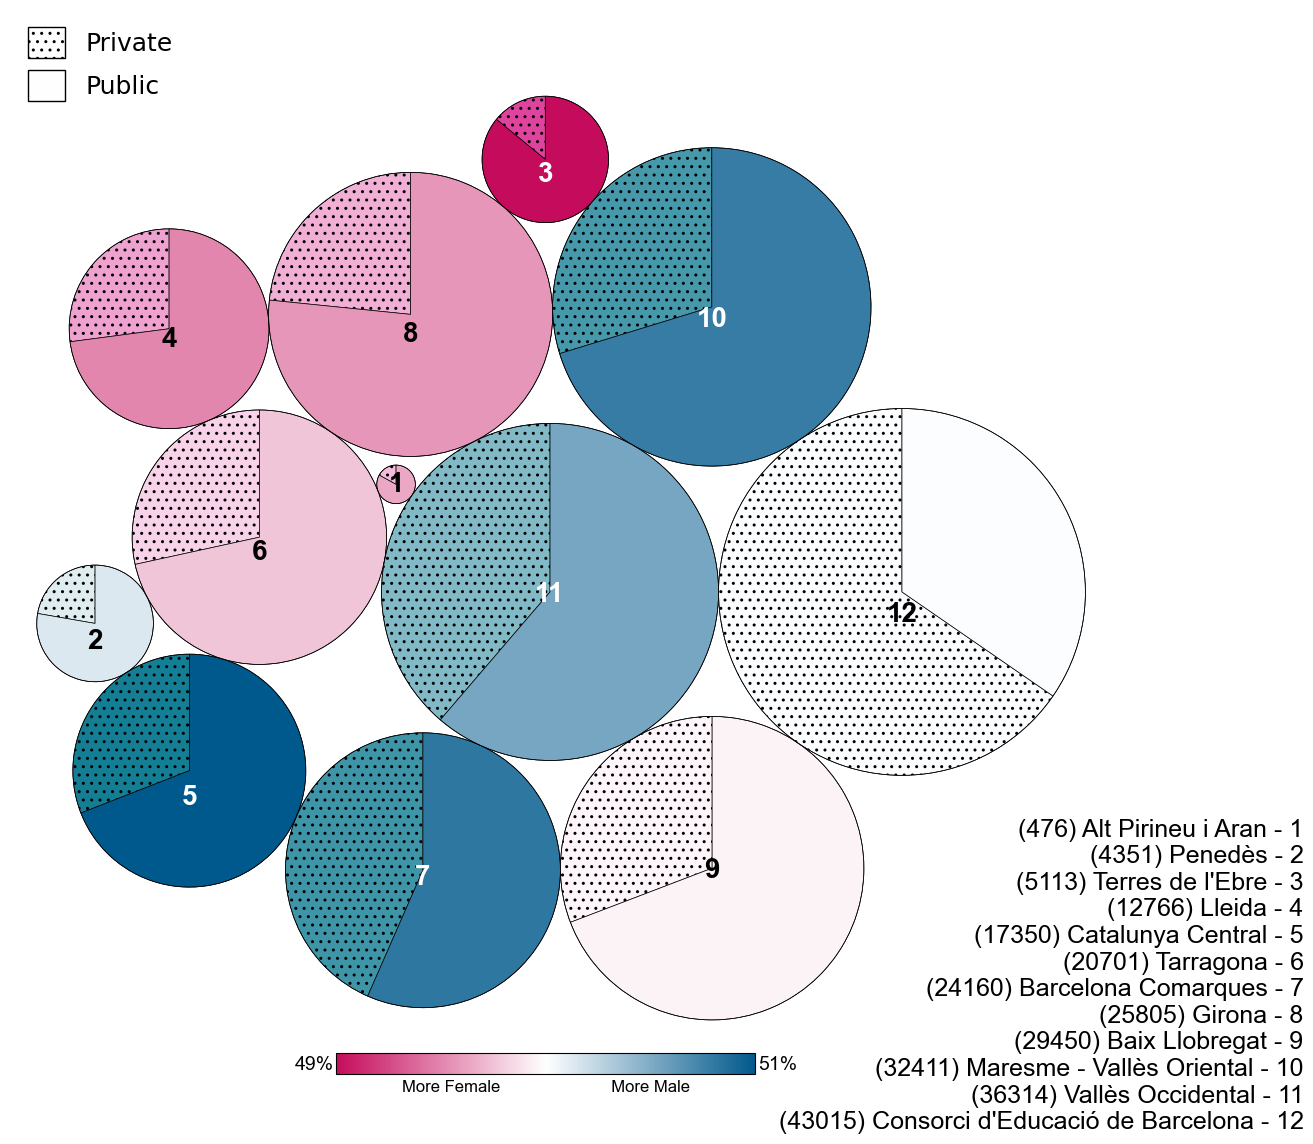

In [11]:
# Aggregate by territory #
g = df_s.groupby("AREA_TERRITORIAL")
area_counts = (df_s.groupby("AREA_TERRITORIAL")["CODI_ALUMNE"].nunique())

# Reorder by size #
area_counts_sorted = area_counts.sort_values(ascending=True)
sizes  = area_counts_sorted.tolist()
labels = area_counts_sorted.index.tolist()

# Circle packing #
circles = circlify.circlify(sizes, show_enclosure=False)

# Priv/Pub Split
nat_pct = df_s.groupby("AREA_TERRITORIAL")["NATURALESA"].value_counts(normalize=True).unstack(fill_value=0)
pct_public = nat_pct["Pública"] 

# Gender per area (0=D, 1=H) #
gen_map = {'D':0, 'H':1}
gen_pct = df_s.assign(GVAL=df_s["GENERE"].map(gen_map)).groupby("AREA_TERRITORIAL")["GVAL"].mean()

# Find catalunya pct for comparison
global_mean = df_s["GENERE"].map(gen_map).mean()
gen_diff = gen_pct - global_mean 

# normalize for div. colormap
gmin, gmax = gen_diff.min(), gen_diff.max()
norm_gen = (lambda v: (v - gmin) / (gmax - gmin) if gmax != gmin else 0.5) 

def custom_diverging_cmap(c1, c2, name="custom_div"):
    return LinearSegmentedColormap.from_list(name, [c1, "white", c2])
cmap2 = custom_diverging_cmap("#C50C5C","#00598C")
cmap = custom_diverging_cmap("#DE449E","#147E95")

# --- PLOT ---
fig, ax = plt.subplots(figsize=(14,14))
ax.set_aspect('equal')
handles = [mpl.patches.Patch(facecolor=cmap(0.5), edgecolor="black", hatch="..", label="Private"), mpl.patches.Patch(facecolor=cmap2(0.5), edgecolor="black", hatch="",  label="Public")]

ax.legend(handles=handles, loc="upper left", fontsize=18, frameon=False, borderpad=0.2, handlelength=1.5, handleheight=1.5)

# draw and fill pies
for i, region in enumerate(labels):

    c = circles[i]
    x, y, r = c.x, c.y, c.r
    
    # Pie wedges (Pub / Priv)
    p_pub = pct_public.loc[region]
    g_color = cmap(norm_gen(gen_diff.loc[region]))
    ax.add_patch(mpl.patches.Wedge((x, y), r, 90, 90 - 360*p_pub, facecolor=g_color, edgecolor="black", hatch="..", linewidth=0.5))

    g_color2 = cmap2(norm_gen(gen_diff.loc[region]))
    ax.add_patch(mpl.patches.Wedge((x, y), r, 90 - 360*p_pub, 90 - 360, facecolor=g_color2, edgecolor="black", linewidth=0.5))

    # Circle outline and text color (based on fill color)
    ax.add_patch(mpl.patches.Circle((x, y), r, fill=False, lw=0.5))
    val = gen_diff.loc[region] 
    threshold = 0.25 * (gmax - gmin)
    if val <= gmin + threshold:
        text_color = "white"      # near min
    elif val >= gmax - threshold:
        text_color = "white"       # near max
    else:
        text_color = "black"     # otherwise

    # Label (slightly jerry-rig to shift numbers down more if larger)
    fontratio=(area_counts[i]/area_counts.max())
    ax.text(x, y, f"{i+1}", ha="center", va="center", position=(x,y-(0.05*fontratio)), fontsize=20, color=text_color, name="Arial", weight="bold")

list_text2 = "\n".join([f"({sizes[i]}) {label} - {i+1}" for i, label in enumerate(labels)])
ax.text(1.2, 0.25,list_text2,transform=ax.transAxes,ha="right",va="top",fontsize=18,name="Arial",bbox=dict(facecolor="white", alpha=0.0,edgecolor="white") )

ax.set_xlim(-1,1)
ax.set_ylim(-1,1)
ax.set_xticks([])
ax.set_yticks([])

cax2 = fig.add_axes([0.36, 0.12, 0.30, 0.015])
cb2 = mpl.colorbar.ColorbarBase(cax2, cmap=cmap2, norm=mpl.colors.Normalize(vmin=gen_pct.min(), vmax=gen_pct.max()), orientation='horizontal', ticks=[])
cb2.set_label("More Female                        More Male", fontsize=12, name="Arial") # spacing works :)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.text(-0.4, -0.94, "49%", ha="right", va="top", fontsize=14, name="Arial")
ax.text(0.46, -0.94, "51%", ha="right", va="top", fontsize=14, name="Arial")
plt.show()

# Save plot
path = Path.cwd()
filename=path.parent.joinpath("Map-Plots/GEOGRAPHY_DEMOGRAPHICS.png")
fig.savefig(filename, dpi=600, bbox_inches='tight')

In [86]:
# CORR MATRIX PLOTS 1 by 1 ( off for now )
""" cols = ['PCAT', 'PCAST', 'PANG', 'PMAT']
secondary_regions.groupby("AREA_TERRITORIAL")
    
secondary_regions_corr = secondary_regions[cols].dropna()
corr=secondary_regions_corr.corr()

plt.figure(figsize=(6,5))
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title(f"Correlation Matrix for Region:")
plt.show()

# Loop over each region
for region_name, group in secondary_regions.groupby("AREA_TERRITORIAL"):
    
    group_clean = group[cols].dropna()

    # Skip regions with not enough data
    if len(group_clean) < 2:
        print(f"Skipping region {region_name}: not enough data")
        continue
    
    corr = group_clean.corr()

    plt.figure(figsize=(6,5))
    sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title(f"Correlation Matrix for Region: {region_name}")
    plt.show() """

' cols = [\'PCAT\', \'PCAST\', \'PANG\', \'PMAT\']\nsecondary_regions.groupby("AREA_TERRITORIAL")\n\nsecondary_regions_corr = secondary_regions[cols].dropna()\ncorr=secondary_regions_corr.corr()\n\nplt.figure(figsize=(6,5))\nsns.heatmap(corr, annot=True, cmap=\'coolwarm\', vmin=-1, vmax=1)\nplt.title(f"Correlation Matrix for Region:")\nplt.show()\n\n# Loop over each region\nfor region_name, group in secondary_regions.groupby("AREA_TERRITORIAL"):\n\n    group_clean = group[cols].dropna()\n\n    # Skip regions with not enough data\n    if len(group_clean) < 2:\n        print(f"Skipping region {region_name}: not enough data")\n        continue\n\n    corr = group_clean.corr()\n\n    plt.figure(figsize=(6,5))\n    sns.heatmap(corr, annot=True, cmap=\'coolwarm\', vmin=-1, vmax=1)\n    plt.title(f"Correlation Matrix for Region: {region_name}")\n    plt.show() '

/var/folders/_m/vj49vq3972b166bph370j1kw0000gn/T/ipykernel_27007/2554196618.py:49: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


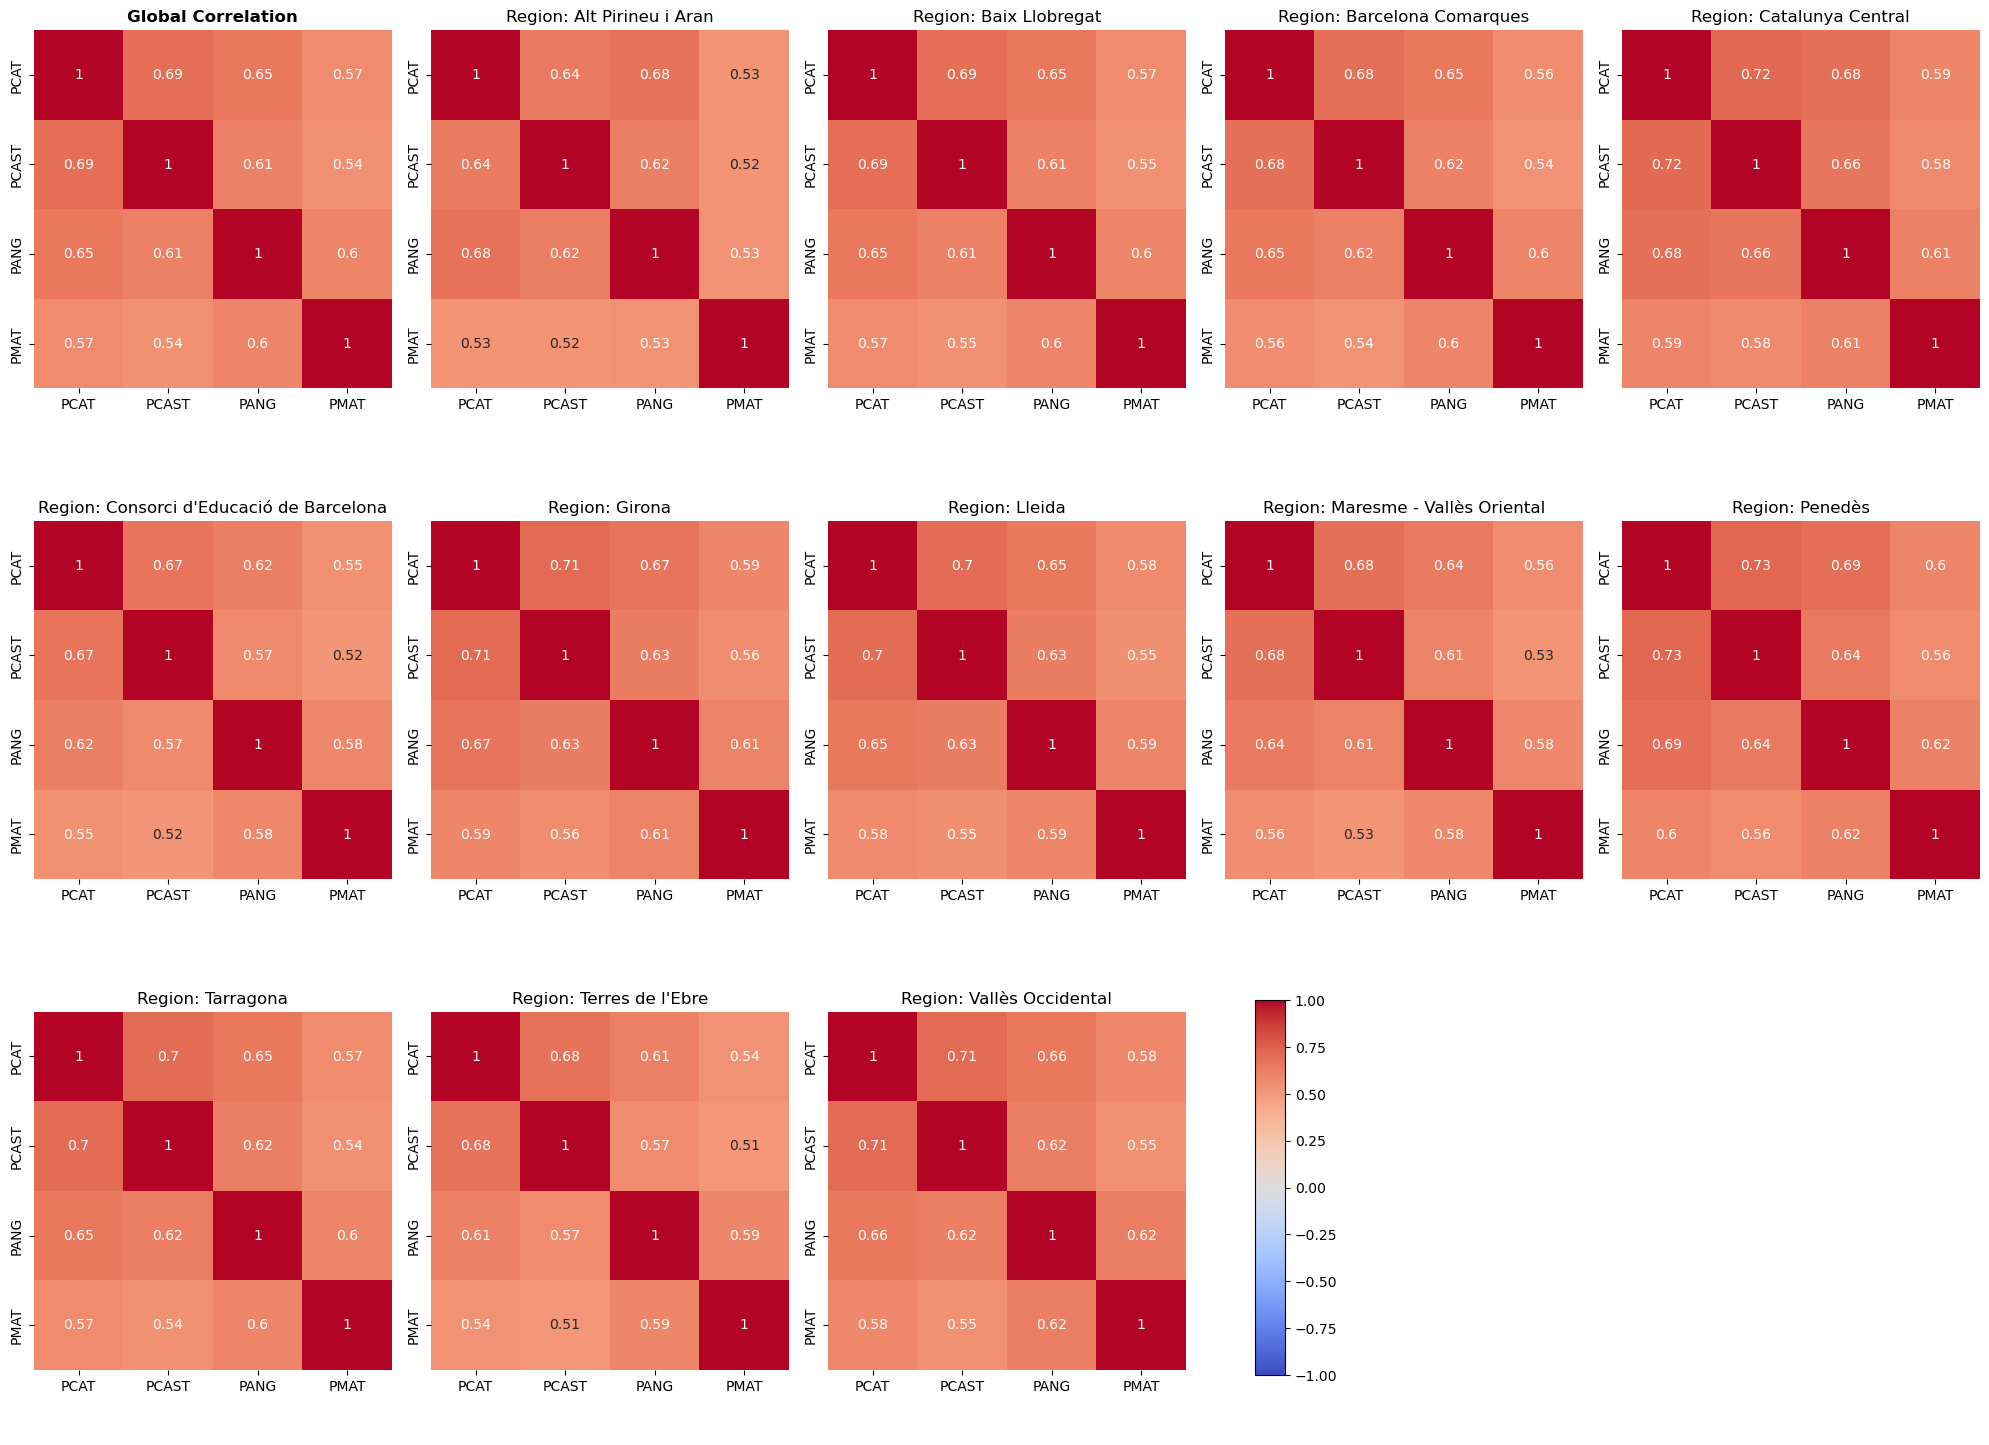

In [87]:
# PLOT ALL CORRELATION HEATMAPS #

cols = ['PCAT', 'PCAST', 'PANG', 'PMAT']

# Compute global correlation
secondary_regions_corr = secondary_regions[cols].dropna()
global_corr = secondary_regions_corr.corr()

# Prepare all region names and correlation matrices
region_corrs = []

for region_name, group in secondary_regions.groupby("AREA_TERRITORIAL"):
    group_clean = group[cols].dropna()

    if len(group_clean) < 2:
        print(f"Skipping region {region_name}: not enough data")
        continue
    
    region_corrs.append((region_name, group_clean.corr()))

# Total plots needed = 1 global + len(regions)
total_plots = 1 + len(region_corrs)

# Set grid size
rows, cols_grid = 3, 5
fig, axes = plt.subplots(rows, cols_grid, figsize=(20, 15))

axes = axes.flatten()

# --- Plot global correlation matrix ---
gbl=sns.heatmap(global_corr, annot=True, cbar=False,cmap='coolwarm', square=True, vmin=-1, vmax=1, ax=axes[0])
axes[0].set_title("Global Correlation", weight="bold")

# --- Plot each region ---
for i, (name, corr) in enumerate(region_corrs, start=1):
    cbar=False
    sns.heatmap(corr, annot=True, cmap='coolwarm', cbar=cbar, square=True, vmin=-1, vmax=1, ax=axes[i])
    axes[i].set_title(f"Region: {name}")

# --- Turn off unused axes ---
for j in range(1 + len(region_corrs), len(axes)):
    axes[j].axis('off')
cbar_ax = fig.add_axes([0.63, 0.05, 0.015, 0.25])  
# [left, bottom, width, height]

# Draw colorbar using the last heatmap
fig.colorbar(gbl.collections[0], cax=cbar_ax)

plt.tight_layout()
plt.show()

# Save plot
path = Path.cwd()
filename=path.parent.joinpath("Map-Plots/GEOGRAPHY_SCORE_CORRELATION_MATRICES.png")
fig.savefig(filename, dpi=600, bbox_inches='tight')

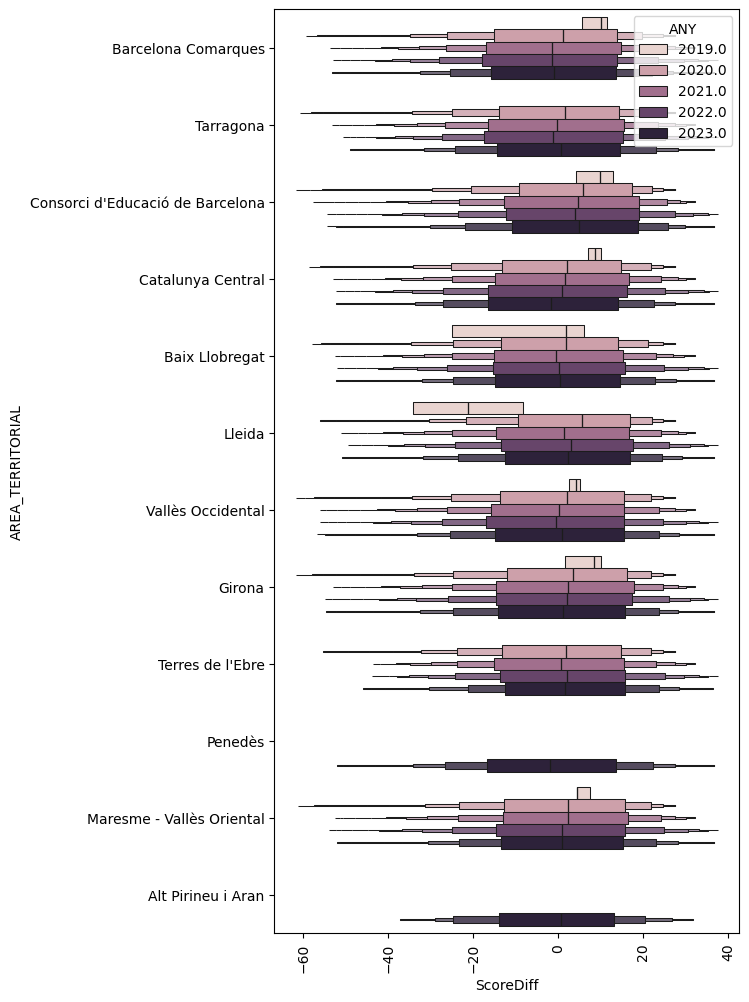

In [88]:
## BAD PLOT + BAD METRIC  ##
## AVG SCORE DIFF FROM TOTAL MEAN ##
numeric_cols = ["PCAT", "PCAST", "PANG", "PMAT"]
counts = (df_s.groupby(["AREA_TERRITORIAL", "ANY"])[numeric_cols].count().reset_index())

# Melt to long format
df_long = df_s.melt(id_vars=["ANY","AREA_TERRITORIAL"], value_vars=numeric_cols, var_name="Examen", value_name="Score")
df_long2 = df_s.melt(id_vars=["NATURALESA"], value_vars=numeric_cols, var_name="Examen", value_name="Score")

df_long = df_long[df_long["Score"].notna()]       # drop NaNs
df_long = df_long[df_long["Score"] != 0]         # drop zeros


## WARNING +1MIN RUN TIME ##
# Plots joint distribution w/ Kernel Density Estimator
plot_long=False
if plot_long==True:    
    plt.figure(figsize=(6,6))
    sns.jointplot(data=df_s,x="PCAT", y="PCAST",hue="NATURALESA", kind="kde", rug=True)
    plt.show()

## Plot avg. score difference from total score mean (of all tests) Not the best metric ##
plt.figure(figsize=(6,12))
df_long["ScoreDiff"] = df_long["Score"] - df_long.groupby(["ANY", "Examen"])["Score"].transform("mean")
sns.boxenplot(x="ScoreDiff",y="AREA_TERRITORIAL",hue="ANY", data=df_long[df_long["Examen"]=="PMAT"],showfliers=False)
plt.xticks(rotation=45)
plt.tick_params(axis='x', labelrotation=90)
plt.show()


In [89]:

numeric_cols = ["PCAT", "PCAST", "PANG", "PMAT"]
pop_nums=df_s["CODI_ALUMNE"].groupby(by=df_s["AREA_TERRITORIAL"]).count().reset_index(name="Pop")
pop_nums = pop_nums.merge(merged_s, left_on="AREA_TERRITORIAL", right_on="NOMREGIO", how="left").reset_index(drop=True)
pop_nums["Pop"]=pop_nums["Pop"].astype(float)
pop_nums.columns
for c in numeric_cols:
    print(f"{c}: {pop_nums[c].mean():.3f} ({pop_nums[c].std():.3f}) (({pop_nums[c].var():.3f}))")


PCAT: 75.245 (1.538) ((2.365))
PCAST: 76.266 (1.809) ((3.273))
PANG: 73.004 (2.012) ((4.050))
PMAT: 65.728 (2.078) ((4.319))


/Users/peterclark/opt/anaconda3/envs/ub-bigdata-viz/lib/python3.11/site-packages/geopandas/geodataframe.py:257: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  super().__setattr__(attr, val)
/var/folders/_m/vj49vq3972b166bph370j1kw0000gn/T/ipykernel_27007/2379201491.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


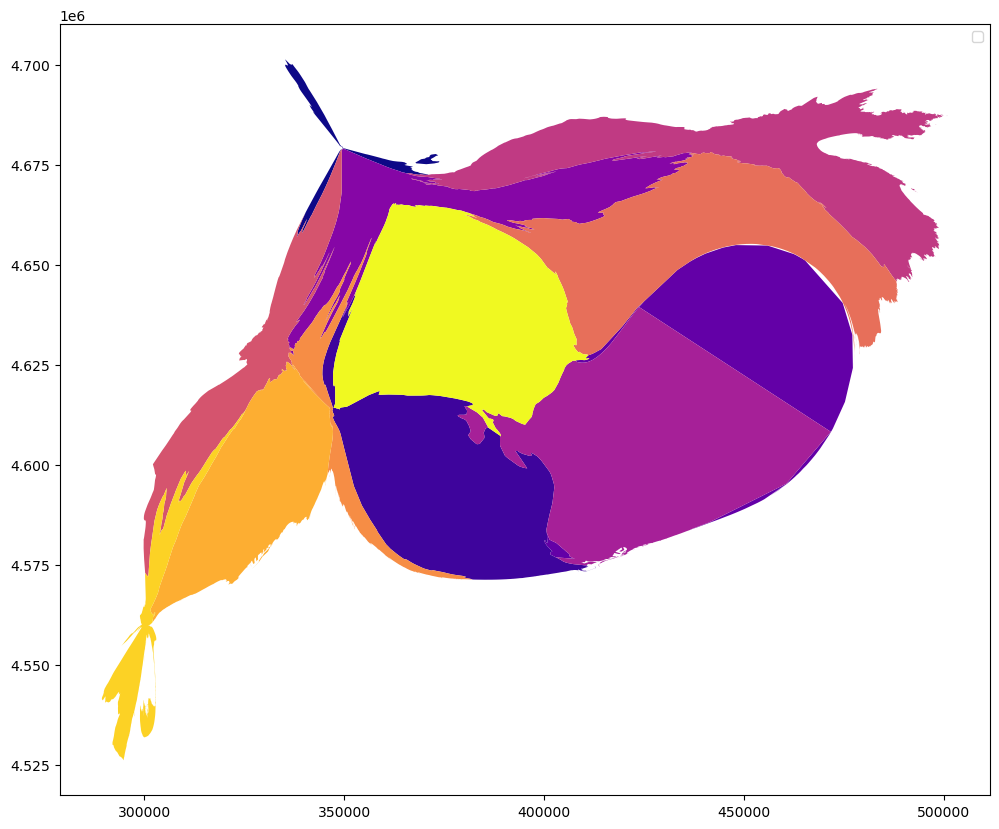

In [90]:
## Cartogram Generation ##
# Unfortuntately, this poorly demonstrates the scale of the pop information #
# and will not be used in the report or presentation. However, too much     #
# went into figuring out how it worked so here it is!                       #
pop_nums.set_geometry("geometry")
pop_nums=gpd.GeoDataFrame(pop_nums)
pop_nums[["geometry", "Pop"]]
geoms=list(pop_nums.geometry)
factor=pop_nums['Pop'].to_numpy()
fig, ax = plt.subplots(figsize=(12,12))
c= cartogram.Cartogram(pop_nums.set_geometry("geometry").reset_index(drop=True), pop_nums['Pop'], max_iterations=100, max_average_error=0.25)
c.plot(ax=ax, cmap='plasma')
ax.legend()
plt.show()

vmin: 61.22499298081422
vmax: 78.15023518918412


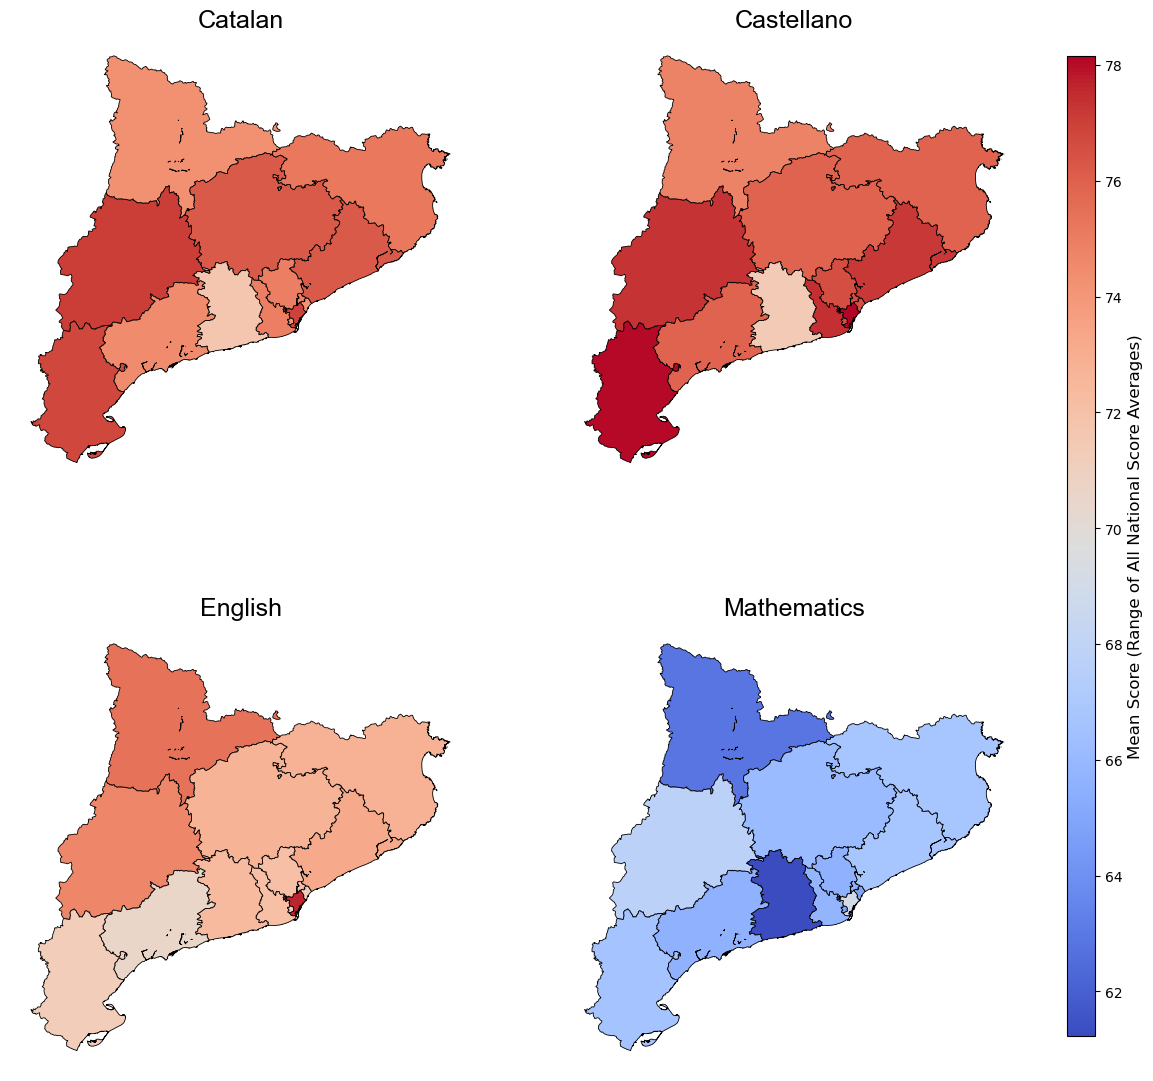

In [196]:
## SECONDARY MEAN TEST-SUBJECT SCORES BY GEOGRAPHICAL REGION ##

fig, ((ax1, ax2),( ax3, ax4)) = plt.subplots(2, 2, figsize=(14, 14))
cmap="coolwarm"

cols = ['PCAT', 'PCAST', 'PANG', 'PMAT']

# Compute the overall min and max across all selected columns
vmin = merged_s[cols].min().min()  # minimum value among all columns
vmax = merged_s[cols].max().max()  # maximum value among all columns
print("vmin:", vmin)
print("vmax:", vmax)

# Plot cols in 2x2 grid #
merged_s.plot(
    column=cols[0],
    cmap=cmap,
    linewidth=0.6,
    edgecolor='black',
    legend=False,
    ax=ax1,
    vmin=vmin,
    vmax=vmax
)
merged_s.plot(
    column=cols[1],
    cmap=cmap,
    linewidth=0.6,
    edgecolor='black',
    legend=False,
    ax=ax2,
    vmin=vmin,
    vmax=vmax
)
merged_s.plot(
    column=cols[2],
    cmap=cmap,
    linewidth=0.6,
    edgecolor='black',
    legend=False,
    ax=ax3,
    vmin=vmin,
    vmax=vmax
)
merged_s.plot(
    column=cols[3],
    cmap=cmap,
    linewidth=0.6,
    edgecolor='black',
    legend=False,
    ax=ax4,
    vmin=vmin,
    vmax=vmax
)

fontsize=18
name="Arial"


ax1.set_axis_off()
ax1.set_title('Catalan', fontsize=fontsize, name=name)
ax2.set_axis_off()
ax2.set_title('Castellano', fontsize=fontsize, name=name)

ax3.set_title('English', fontsize=fontsize, name=name)
ax2.set_axis_off()
ax4.set_title('Mathematics', fontsize=fontsize, name=name)

ax3.set_axis_off()
ax4.set_axis_off()
fig.subplots_adjust(right=0.85)  # leave 15% of figure width on the right

# --- Shared colorbar on the right ---
sm = mpl.cm.ScalarMappable(cmap=cmap, norm=mpl.colors.Normalize(vmin=vmin, vmax=vmax))
sm._A = []

cbar_ax = fig.add_axes([0.88, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar.set_label("Mean Score (Range of All National Score Averages)", fontsize=12)

#plt.tight_layout()
plt.show()

# Save plot
path = Path.cwd()
filename=path.parent.joinpath("Map-Plots/GEOGRAPHY_MEAN_SCORES.png")
fig.savefig(filename, dpi=600, bbox_inches='tight')

vmin: -4.822438297894351
vmax: 4.618636690273576


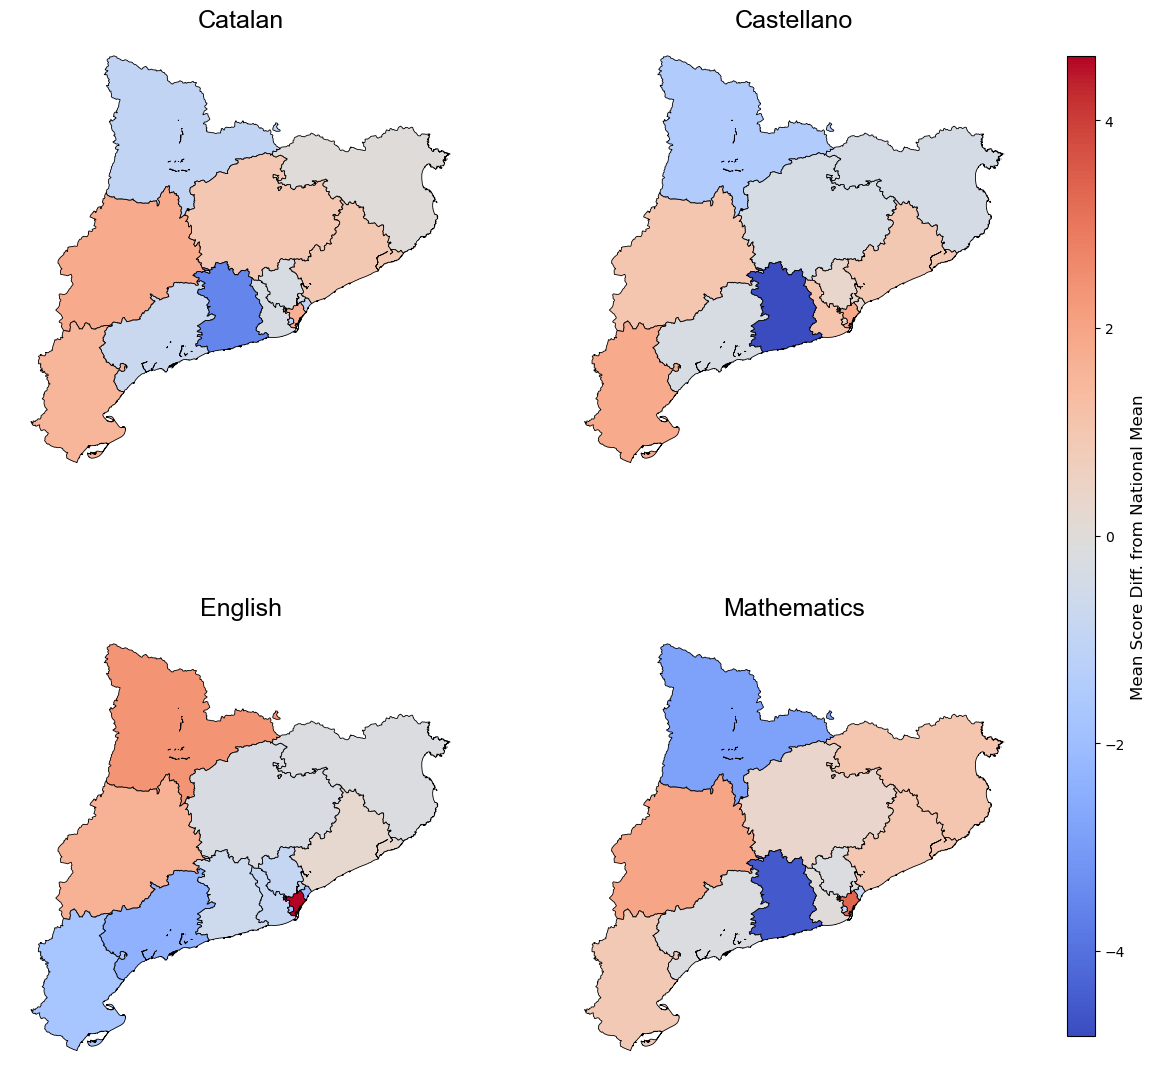

In [195]:
## SECONDARY MEAN TEST-SUBJECT SCORES BY GEOGRAPHICAL REGION ##

fig, ((ax1, ax2),( ax3, ax4)) = plt.subplots(2, 2, figsize=(14, 14))
cmap="coolwarm"

cols = ['PCAT', 'PCAST', 'PANG', 'PMAT']
merged_s_norm = merged_s.copy()
for c in cols:
    merged_s_norm[c] = merged_s[c]-merged_s[c].mean()
# Compute the overall min and max across all selected columns
vmin = merged_s_norm[cols].min().min()  # minimum value among all columns
vmax = merged_s_norm[cols].max().max()  # maximum value among all columns
print("vmin:", vmin)
print("vmax:", vmax)

# Plot cols in 2x2 grid #
merged_s_norm.plot(
    column=cols[0],
    cmap=cmap,
    linewidth=0.6,
    edgecolor='black',
    legend=False,
    ax=ax1,
    vmin=vmin,
    vmax=vmax
)
merged_s_norm.plot(
    column=cols[1],
    cmap=cmap,
    linewidth=0.6,
    edgecolor='black',
    legend=False,
    ax=ax2,
    vmin=vmin,
    vmax=vmax
)
merged_s_norm.plot(
    column=cols[2],
    cmap=cmap,
    linewidth=0.6,
    edgecolor='black',
    legend=False,
    ax=ax3,
    vmin=vmin,
    vmax=vmax
)
merged_s_norm.plot(
    column=cols[3],
    cmap=cmap,
    linewidth=0.6,
    edgecolor='black',
    legend=False,
    ax=ax4,
    vmin=vmin,
    vmax=vmax
)

fontsize=18
name="Arial"

ax1.set_axis_off()
ax1.set_title('Catalan', fontsize=fontsize, name=name)
ax2.set_axis_off()
ax2.set_title('Castellano', fontsize=fontsize, name=name)

ax3.set_title('English', fontsize=fontsize, name=name)
ax2.set_axis_off()
ax4.set_title('Mathematics', fontsize=fontsize, name=name)

ax3.set_axis_off()
ax4.set_axis_off()
fig.subplots_adjust(right=0.85)  # leave 15% of figure width on the right

# --- Shared colorbar on the right ---
sm = mpl.cm.ScalarMappable(cmap=cmap, norm=mpl.colors.Normalize(vmin=vmin, vmax=vmax))
sm._A = []

cbar_ax = fig.add_axes([0.88, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar.set_label("Mean Score Diff. from National Mean", fontsize=12)

#plt.tight_layout()
plt.show()

# Save plot
path = Path.cwd()
filename=path.parent.joinpath("Map-Plots/GEOGRAPHY_MEAN_SCOREDIFFERENCE.png")
fig.savefig(filename, dpi=600, bbox_inches='tight')

[70.55 82.32]
[71.93 82.7 ]
[67.6 87. ]
[54.815 76.575]


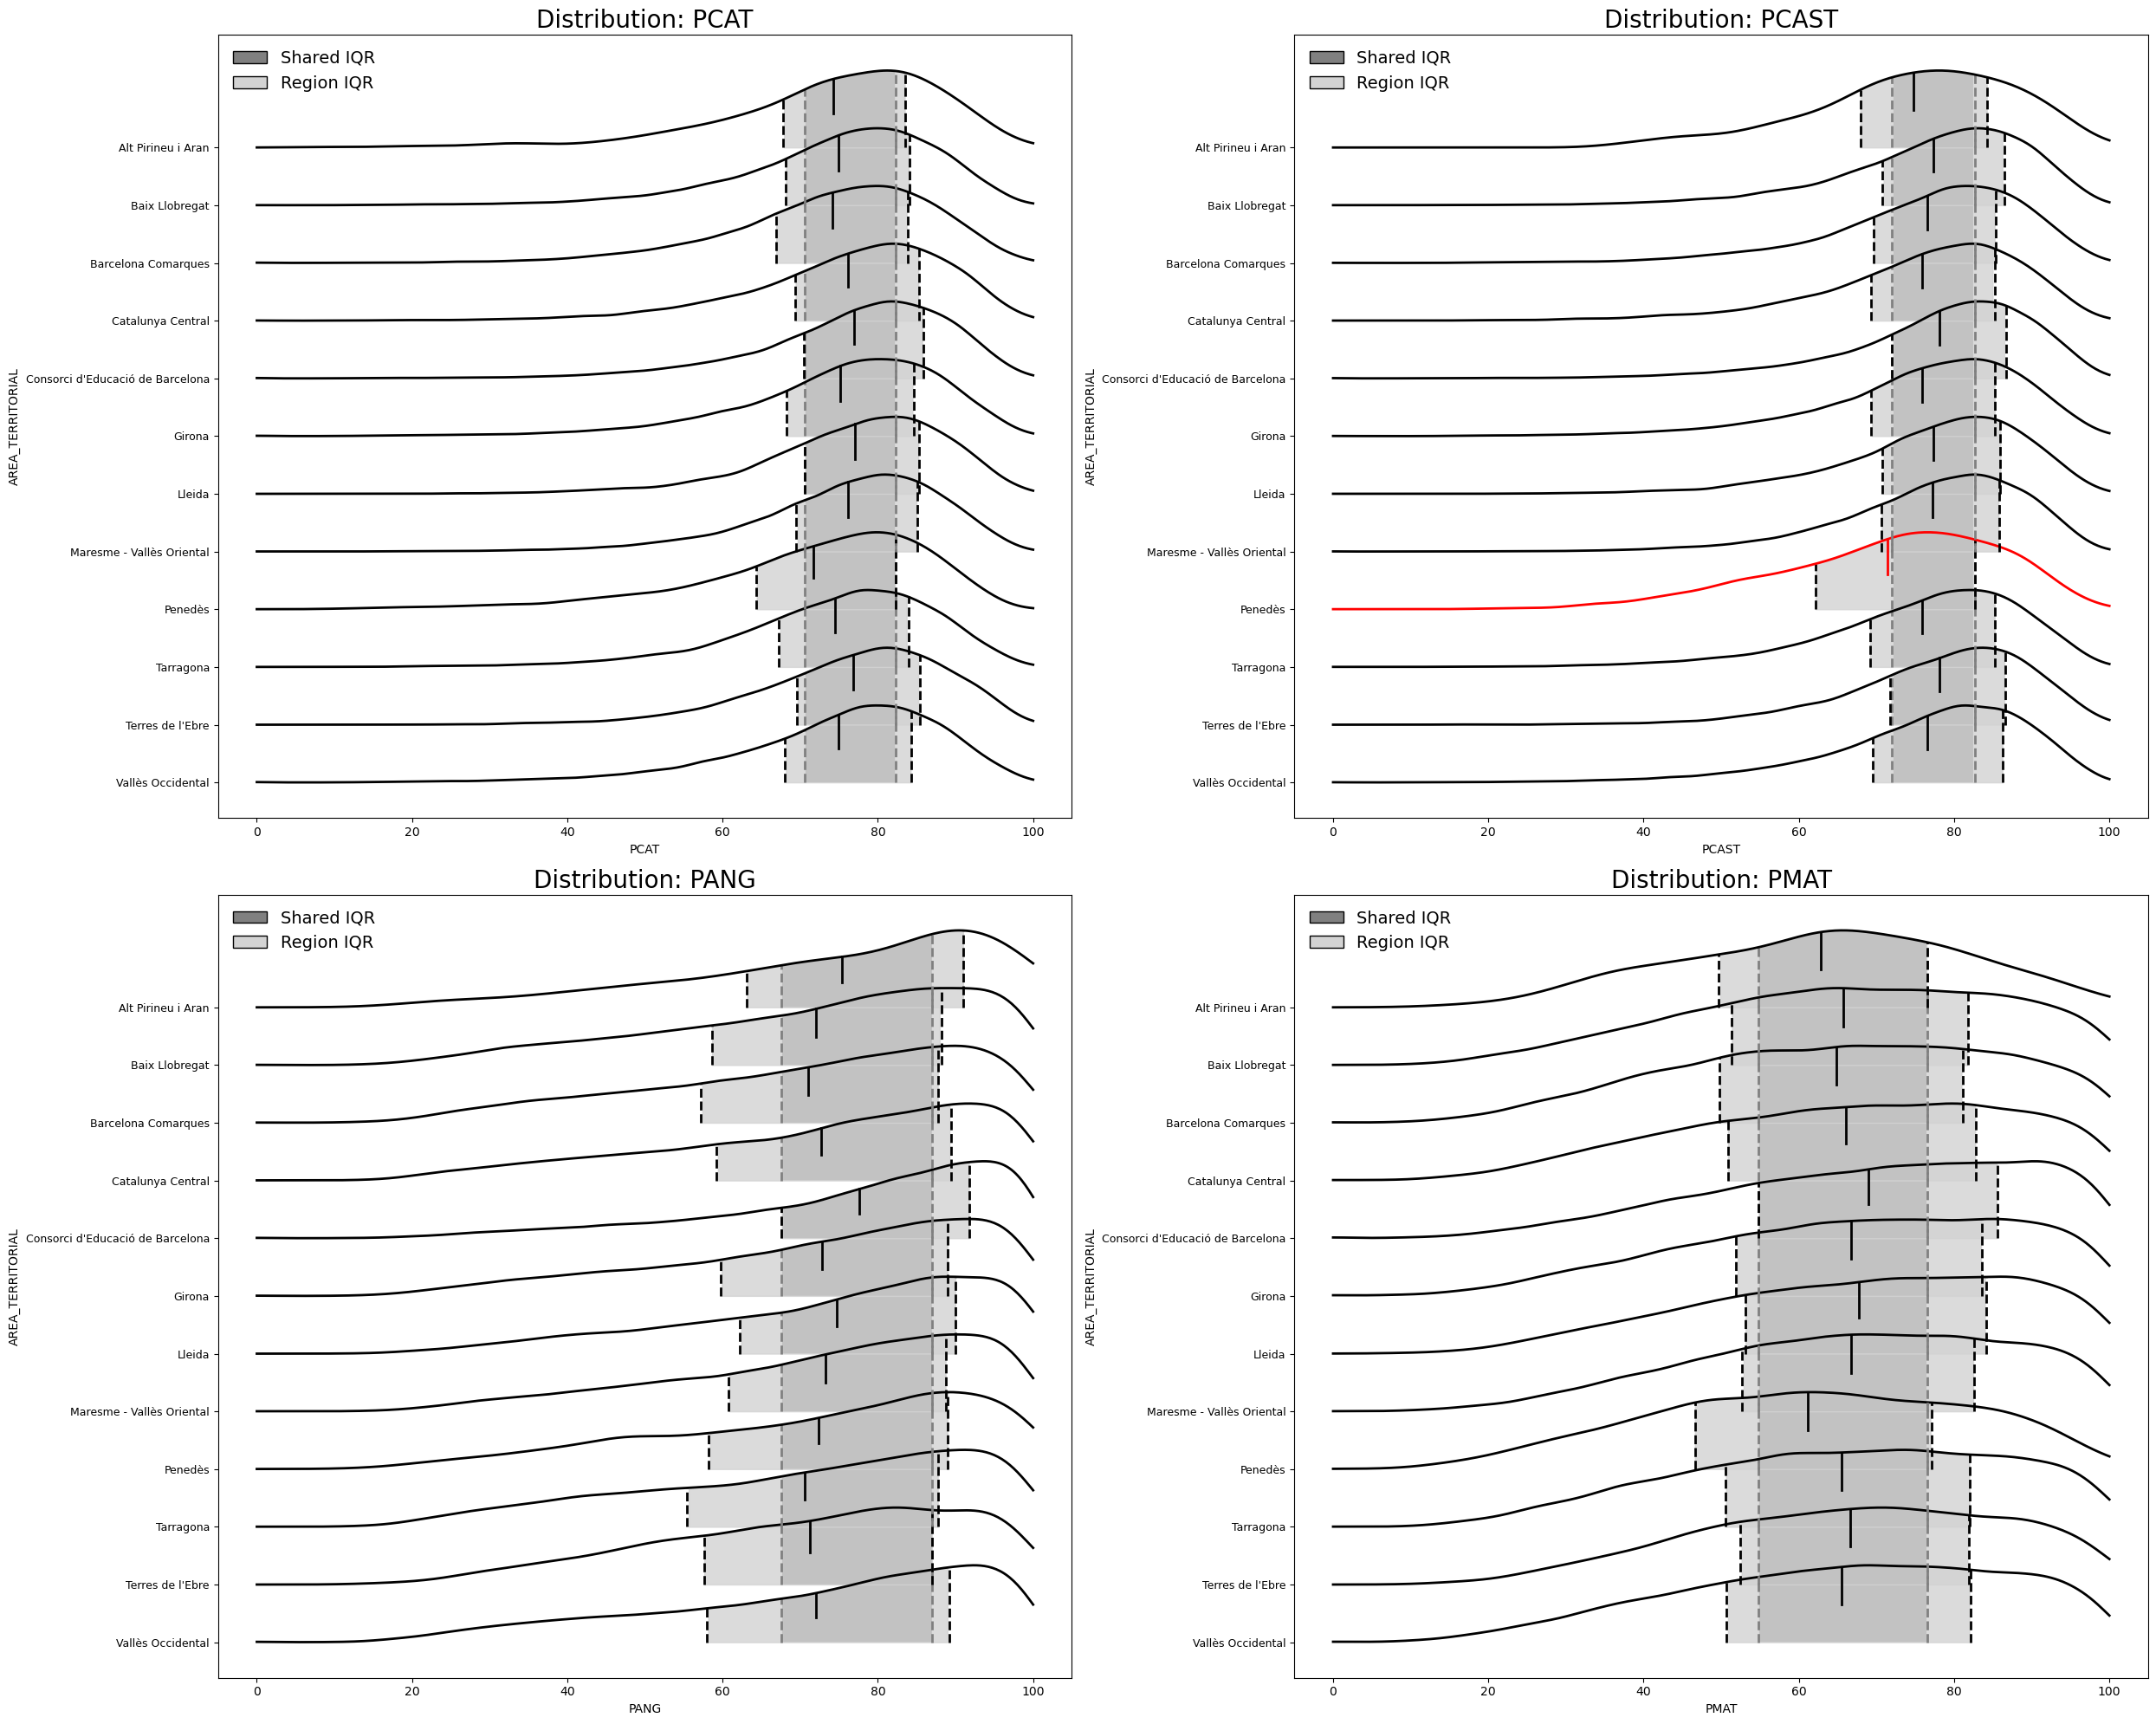

In [194]:
from scipy.stats import gaussian_kde

cols = ['PCAT', 'PCAST', 'PANG', 'PMAT']
areas = sorted(secondary_regions['AREA_TERRITORIAL'].dropna().unique())[::-1]

fig, axes = plt.subplots(2, 2, figsize=(25, 20))
axes = axes.flatten()

for ax, col in zip(axes, cols):

    # vertical spacing between ridges
    offset = 0.75  

    # shared x-range for all area KDEs
    col_data = secondary_regions[col].dropna()
    xmin, xmax = col_data.min(), col_data.max()
    xs = np.linspace(xmin, xmax, 400)
    iqr=[]
    for i, area in enumerate(areas):
        subset = secondary_regions.loc[
            secondary_regions["AREA_TERRITORIAL"] == area, col
        ].dropna()
        q1 = subset.quantile(0.25)
        q3 = subset.quantile(0.75)
        iqr.append([q1,q3])
    iqr=np.array(iqr)
    iqr_all = np.array( [np.max(iqr[:,0]), np.min(iqr[:,1])] )
    print(iqr_all)
    for i, area in enumerate(areas):

        subset = secondary_regions.loc[
            secondary_regions["AREA_TERRITORIAL"] == area, col
        ].dropna()

        if len(subset) < 2:
            continue

        # Compute KDE safely
        kde = gaussian_kde(subset)
        y = kde(xs)

        # Normalize height so big groups don’t dominate
        y = y / y.max()

        all_q1, all_q3 = iqr_all   # same for all areas
        mask = (xs >= all_q1) & (xs <= all_q3)
        ax.fill_between(xs[mask], i*offset, (y + i*offset)[mask], facecolor='gray')
        ax.plot([all_q1, all_q1], [i*offset, y[mask][0] + i*offset], color="gray", linewidth=2, linestyle="--")
        ax.plot([all_q3, all_q3], [i*offset, y[mask][-1] + i*offset], color="gray", linewidth=2, linestyle="--")

        mu = subset.mean()
        sd = subset.std()
        low = mu - 2*sd
        high = mu + 2*sd
        q1 = subset.quantile(0.25)
        q3 = subset.quantile(0.75)
        low, high = q1, q3
        mask = (xs >= low) & (xs <= high)

        ax.fill_between(xs[mask], i*offset, (y + i*offset)[mask], color="lightgray",alpha=0.8)
        ax.plot([q1,q1], [i*offset, y[mask][0] + i*offset], color="black", linewidth=2, linestyle="--")
        ax.plot([q3,q3], [i*offset, y[mask][-1] + i*offset], color="black", linewidth=2, linestyle="--")

        
        # Shift ridge up
        #ax.fill_between(xs, i*offset, y + i*offset, alpha=0.6, color="dimgray")
        color="red" if mu>all_q3 or mu <all_q1 else "black"
        ax.plot(xs, y + i*offset, linewidth=2, color=color)

        y_mu = kde([mu])[0]    # normalized to same scale as y
        y_mu /= y.max()
        idx = np.abs(xs - mu).argmin()
        y_mu = y[idx]
        
        ax.plot([mu, mu], [(y_mu/2)+i*offset, y_mu + i*offset], color=color, linewidth=2, linestyle="-")



    # Label ridge levels
    ax.set_yticks([i * offset for i in range(len(areas))])
    ax.set_yticklabels(areas, fontsize=9)

    ax.set_title(f"Distribution: {col}", fontsize=20)
    ax.set_xlabel(col)
    ax.set_ylabel("AREA_TERRITORIAL")
    legend_patches = [
        mpl.patches.Patch(facecolor='gray', edgecolor='black', label='Shared IQR'),
        mpl.patches.Patch(facecolor='lightgray', edgecolor='black', label='Region IQR')
    ]

    ax.legend(handles=legend_patches,
            loc='upper left',    # adjust as needed
            fontsize=14,
            frameon=False)

plt.tight_layout()
plt.show()
# Save plot
path = Path.cwd()
filename=path.parent.joinpath("Map-Plots/GEOGRAPHY_SCORE_DISTRIBUTIONS.png")
fig.savefig(filename, dpi=600, bbox_inches='tight')


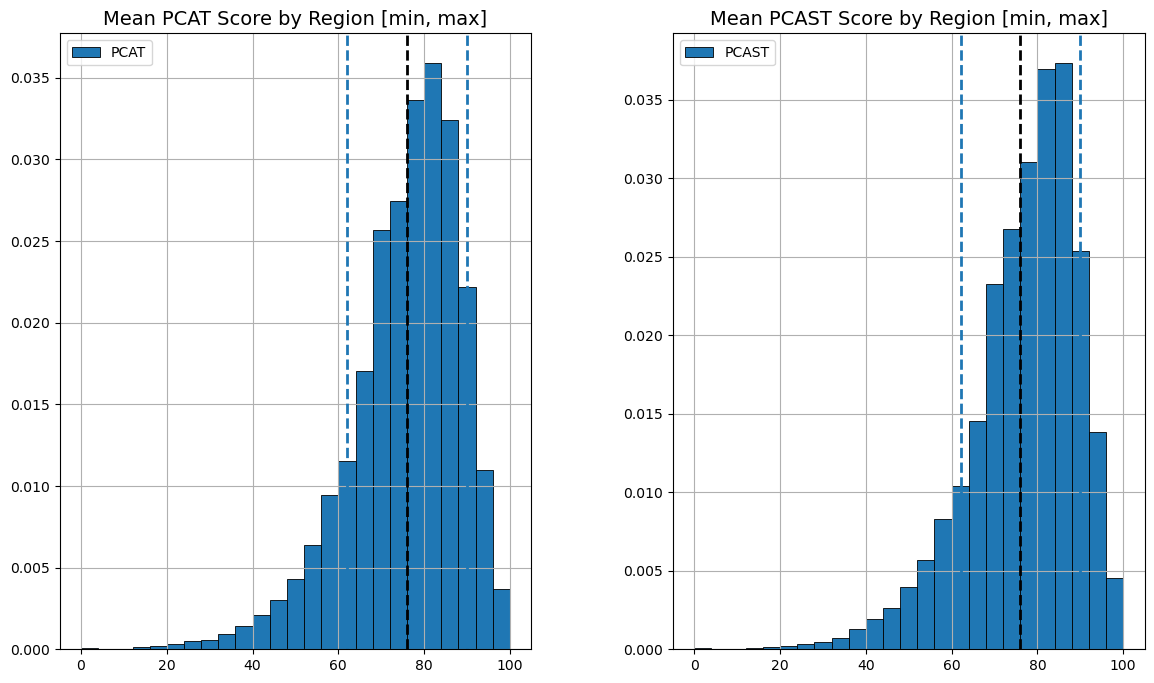

In [ ]:
# Auxiliary exploration graphs #

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 8))

vmin = min(merged_s['PCAST'].min(),merged_s['PCAT'].min())
vmax =max(merged_s['PCAST'].max(),merged_s['PCAT'].max())

df_s.hist(
    column='PCAT',
    linewidth=0.6,
    edgecolor='black',
    bins=25,
    legend=True,
    ax=ax1,
    density=True
)

df_s.hist(
    column='PCAST',
    linewidth=0.6,
    edgecolor='black',
    legend=True,
    ax=ax2,
    bins=25,
    density=True
    
)
ax1.axvline(x=df_p["PCAT"].mean()-df_p["PCAT"].std(), linewidth=2,linestyle="--")
ax1.axvline(x=df_p["PCAT"].mean()+df_p["PCAT"].std(), linewidth=2,linestyle="--")
ax1.axvline(x=df_p["PCAT"].mean(), color="black" ,linewidth=2,linestyle="--")
#ax1.set_axis_off()
ax1.set_title('Mean PCAT Score by Region [min, max]', fontsize=14)
#ax2.set_axis_off()
ax2.set_title('Mean PCAST Score by Region [min, max]', fontsize=14)
ax2.axvline(x=df_p["PCAT"].mean()-df_p["PCAT"].std(), linewidth=2,linestyle="--")
ax2.axvline(x=df_p["PCAT"].mean()+df_p["PCAT"].std(), linewidth=2,linestyle="--")
ax2.axvline(x=df_p["PCAT"].mean(), color="black" ,linewidth=2,linestyle="--")

ax3.set_axis_off()
ax4.set_axis_off()
plt.show()

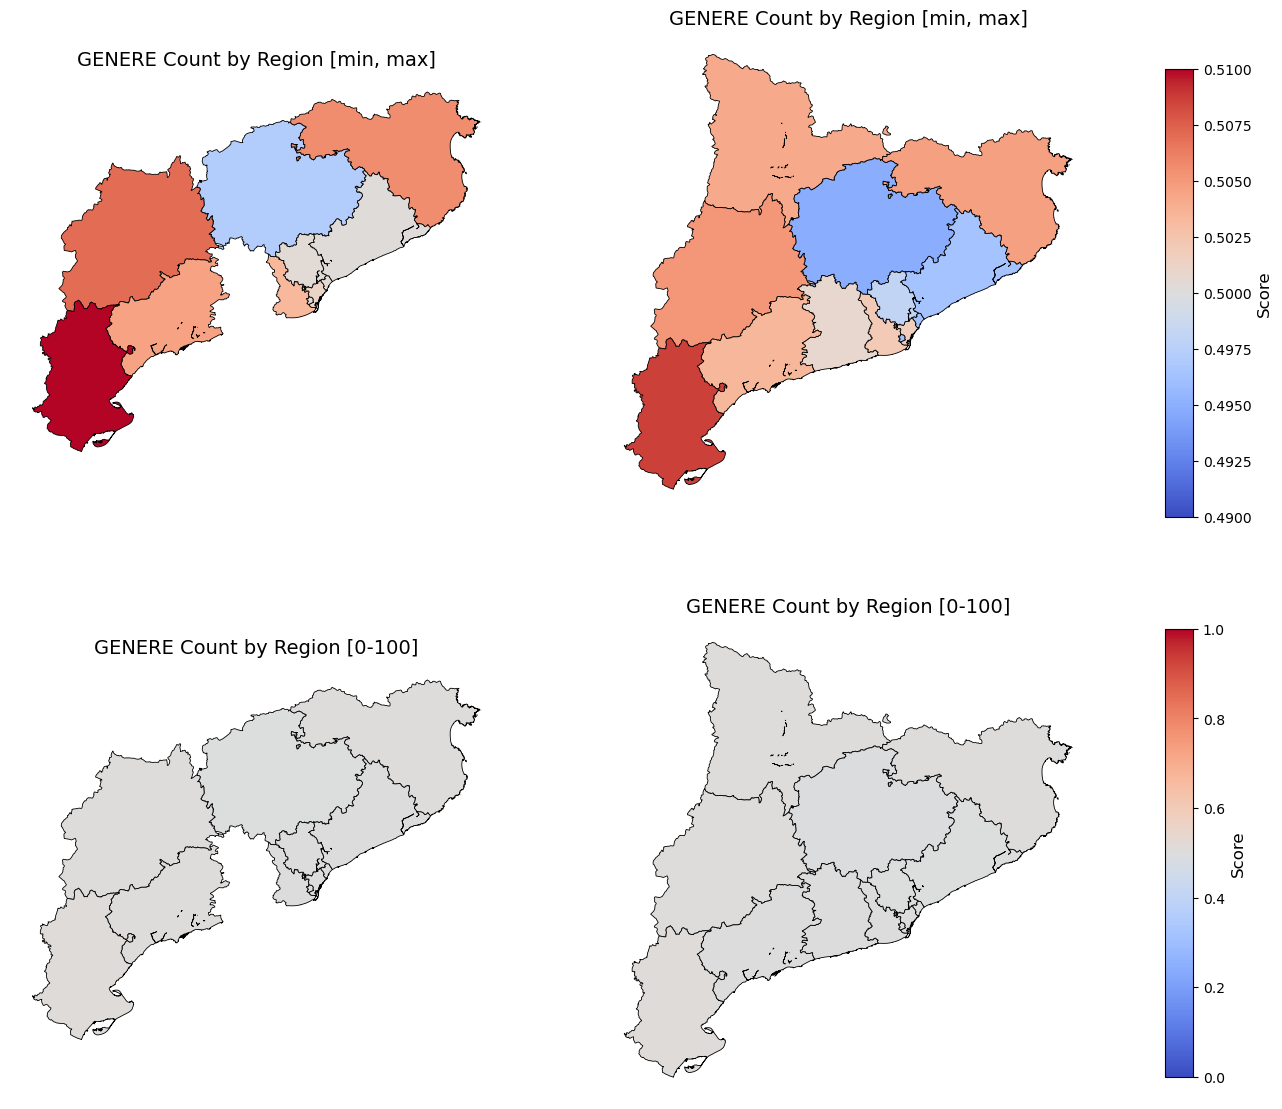

In [94]:
## !!! NOTE ABOUT GEO. DISTRIBUTION !!! ##
## Department of Education in the period between primary and secondary competencies scores for individuals
## changed the organization of the regions from 10->12 and shuffling municipalities.
## This was easily correctlible for the secondary dataset, but you can see here that 
## the primary dataset doesn't follow the same exact organization. (We did not want to change the original dataset
## to adjust to the new labels, as at the time of measurements, they weren't labelled like that and
## more importantly, we don't have fine scale information to redistribute into new labels.

ratio_s = (df_s.groupby("AREA_TERRITORIAL",as_index=False)["GENERE"].apply(lambda x: (x == "D").sum() / x.count()))
merged_s_ratio = regions.merge(ratio_s, left_on="NOMREGIO", right_on="AREA_TERRITORIAL", how="left")

ratio_p = (df_p.groupby("AREA_TERRITORIAL",as_index=False)["GENERE"].apply(lambda x: (x == "D").sum() / x.count()))
merged_p_ratio = regions.merge(ratio_p, left_on="NOMREGIO", right_on="AREA_TERRITORIAL", how="left")

fig, ((ax1, ax2),( ax3, ax4)) = plt.subplots(2, 2, figsize=(14, 14))
cmap='coolwarm'

# Plot relative differences [+- 1% is a nice margin to show variation within bounds]
vmin = min(merged_s_ratio['GENERE'].min(),merged_p_ratio['GENERE'].min())
vmax =max(merged_s_ratio['GENERE'].max(),merged_p_ratio['GENERE'].max())
vmin,vmax=0.49, 0.51
merged_p_ratio.plot(column='GENERE', cmap=cmap, linewidth=0.6, edgecolor='black', legend=False, ax=ax1, vmin=vmin, vmax=vmax)
merged_s_ratio.plot(column='GENERE', cmap=cmap, linewidth=0.6, edgecolor='black', legend=False, ax=ax2, vmin=vmin, vmax=vmax)

sm = mpl.cm.ScalarMappable(cmap=cmap, norm=mpl.colors.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbar_ax = fig.add_axes([0.95, 0.53, 0.02, 0.32])  # [left, bottom, width, height]
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar.set_label("Score", fontsize=12)

# Plot raw number to show total discrepancy
vmin,vmax=0,1
merged_p_ratio.plot(column='GENERE', cmap=cmap, linewidth=0.6, edgecolor='black', legend=False, ax=ax3, vmin=vmin, vmax=vmax)
merged_s_ratio.plot(column='GENERE', cmap=cmap, linewidth=0.6, edgecolor='black', legend=False, ax=ax4, vmin=vmin, vmax=vmax)

sm = mpl.cm.ScalarMappable(cmap=cmap, norm=mpl.colors.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbar_ax = fig.add_axes([0.95, 0.13, 0.02, 0.32])  # [left, bottom, width, height]
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar.set_label("Score", fontsize=12)

ax1.set_axis_off()
ax1.set_title('GENERE Count by Region [min, max]', fontsize=14)
ax2.set_axis_off()
ax2.set_title('GENERE Count by Region [min, max]', fontsize=14)

ax3.set_title('GENERE Count by Region [0-100]', fontsize=14)
ax2.set_axis_off()
ax4.set_title('GENERE Count by Region [0-100]', fontsize=14)

ax3.set_axis_off()
ax4.set_axis_off()
plt.show()

# Save plot
path = Path.cwd()
filename=path.parent.joinpath("Map-Plots/GEOGRAPHY_GENDER_RATIO.png")
fig.savefig(filename, dpi=600, bbox_inches='tight')